# Haberman’s Survival Data Set

The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.

Attribute Information:

- Age of patient at time of operation (numerical)
- Patient's year of operation (year - 1900, numerical)
- Number of positive axillary nodes detected (numerical)
- Survival status (class attribute)
- 1 = the patient survived 5 years or longer 2 = the patient died within 5 year

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, recall_score, precision_score, auc
from sklearn.metrics import classification_report, f1_score, fbeta_score


In [2]:
df_cancer = pd.read_csv('haberman.csv')
df_cancer.columns = ['age' , 'operation_year' , 'axil_node' , 'survived_status']

In [3]:
df_cancer.tail()

,age,operation_year,axil_node,survived_status
300,75,62,1,1
301,76,67,0,1
302,77,65,3,1
303,78,65,1,2
304,83,58,2,2


In [4]:
df_cancer.describe()

,age,operation_year,axil_node,survived_status
count,305.000000,305.000000,305.000000,305.000000
mean,52.531148,62.849180,4.036066,1.265574
std,10.744024,3.254078,7.199370,0.442364
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,61.000000,66.000000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


In [5]:
df_cancer['survived_status'].value_counts(sum)

1    0.734426
2    0.265574
Name: survived_status, dtype: float64

unbalanced base

In [6]:
df_cancer['survived_status'] = df_cancer['survived_status'].map({1:0 , 2:1})
df_cancer.tail()

,age,operation_year,axil_node,survived_status
300,75,62,1,0
301,76,67,0,0
302,77,65,3,0
303,78,65,1,1
304,83,58,2,1


Survived Status:
- 1 : Survived 5 years or longer
- 2 : The patient died within 5 year

# Adjustment of Logistic Regression

In [7]:
function_formula = 'survived_status ~ age + operation_year + axil_node'
log_reg = smf.logit(formula = function_formula , data = df_cancer)
log_reg = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.537621
         Iterations 5


In [8]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:        survived_status   No. Observations:                  305
Model:                          Logit   Df Residuals:                      301
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Jan 2023   Pseudo R-squ.:                 0.07116
Time:                        21:36:34   Log-Likelihood:                -163.97
converged:                       True   LL-Null:                       -176.54
Covariance Type:            nonrobust   LLR p-value:                 1.455e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.8561      2.673     -0.694      0.487      -7.095       3.383
age                0.0193      0.013      1.511      0.131      -0.006       0.044
operation_year    -0.0093      0.042

## Interpretation of the Betas

In [9]:
print(np.exp(log_reg.params))

Intercept         0.156285
age               1.019522
operation_year    0.990716
axil_node         1.092142
dtype: float64


- age : For each additional year for the patients in this observations , the chance of die within 5 years increase 1.9%
- operation_year : For each additional year for operation year in this observations , the chance of die within 5 years decrease in -0.93% 
- axil_node : For each additional node, the chance of die within 5 years increase in 9.21%

# Metrics

## F-Beta Score

In [10]:
X = df_cancer.drop('survived_status' , axis = 1)
Y = df_cancer['survived_status']

In [11]:
Y_predict = log_reg.predict(X)

In [12]:
f1_scores = []
f0_5_scores = []
f2_scores = []
precision_scores = []
recall_scores = []


thresholds = np.linspace(0, 1, num=100)

In [13]:
for thresh in thresholds:
    
    y_predict_bool = Y_predict >= thresh
    f1 = f1_score(Y, y_predict_bool)
    f0_5 = fbeta_score(Y, y_predict_bool, beta=0.5)
    f2 = fbeta_score(Y, y_predict_bool, beta=2)
    precision = precision_score(Y, y_predict_bool , zero_division = 1)
    recall = recall_score(Y, y_predict_bool)
        
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    precision_scores.append(precision)
    recall_scores.append(recall)

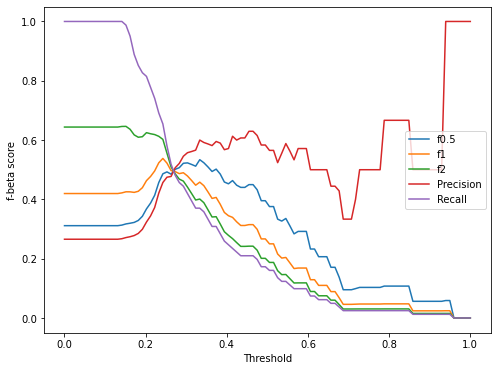

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(thresholds, f0_5_scores , label='f0.5')
ax.plot(thresholds, f1_scores, label='f1')
ax.plot(thresholds, f2_scores, label='f2')
ax.plot(thresholds, precision_scores, label='Precision')
ax.plot(thresholds, recall_scores, label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='center right');

As the base is unbalanced we must use Precision. In this way we look at the blue line (f 0.5)

## Curva ROC

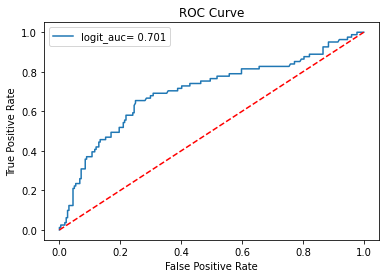

In [16]:
fpr,tpr,thresholds = roc_curve(Y,Y_predict)

logit_auc = roc_auc_score(Y,Y_predict)

plt.plot(fpr,tpr,label='logit_auc= %0.3f'%logit_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

## Curva PR

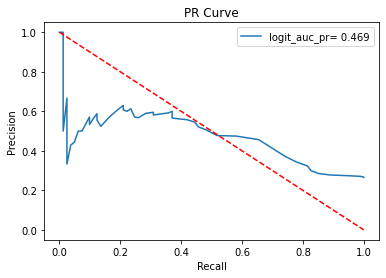

In [17]:
auc_pr = auc(recall_scores, precision_scores)

plt.plot(recall_scores,precision_scores,label='logit_auc_pr= %0.3f'%auc_pr)
plt.plot([0,1],[1,0],'r--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc='best')
plt.show()